In [1]:
from datasets import load_dataset, DatasetDict, Dataset

from transformers import (
    AutoTokenizer,
    AutoConfig, 
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer)

from peft import PeftModel, PeftConfig, get_peft_model, LoraConfig
import evaluate
import torch
import tensorflow as tf
import numpy as np
import pandas as pd

C:\Users\abhishek.singh3\AppData\Local\anaconda3\Lib\site-packages\bitsandbytes\cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
  warn("The installed version of bitsandbytes was compiled without GPU support. "


'NoneType' object has no attribute 'cadam32bit_grad_fp32'


In [49]:
#Read data
df=pd.read_csv('legal_text_classification.csv', usecols=["case_outcome", "case_title", "case_text"] )
df.head()

,case_outcome,case_title,case_text
0,cited,Alpine Hardwood (Aust) Pty Ltd v Hardys Pty Lt...,Ordinarily that discretion will be exercised s...
1,cited,Black v Lipovac [1998] FCA 699 ; (1998) 217 AL...,The general principles governing the exercise ...
2,cited,Colgate Palmolive Co v Cussons Pty Ltd (1993) ...,Ordinarily that discretion will be exercised s...
3,cited,Dais Studio Pty Ltd v Bullett Creative Pty Ltd...,The general principles governing the exercise ...
4,cited,Dr Martens Australia Pty Ltd v Figgins Holding...,The preceding general principles inform the ex...


In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24985 entries, 0 to 24984
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   case_outcome  24985 non-null  object
 1   case_title    24985 non-null  object
 2   case_text     24809 non-null  object
dtypes: object(3)
memory usage: 585.7+ KB


In [51]:
df.isnull().sum()

case_outcome      0
case_title        0
case_text       176
dtype: int64

In [52]:
df['case_outcome'].unique()

array(['cited', 'applied', 'followed', 'referred to', 'related',
       'considered', 'discussed', 'distinguished', 'affirmed', 'approved'],
      dtype=object)

<Axes: xlabel='case_outcome'>

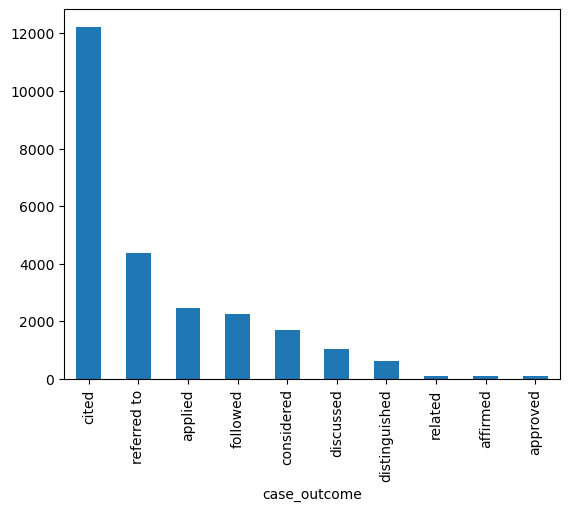

In [53]:
df['case_outcome'].value_counts().sort_values(ascending=False).plot(kind='bar')

In [54]:
#preprocessing
df=df.dropna(how='any')

df['text']= df['case_title'] +" " +df['case_text']
df['text'] = df['text'].fillna('').astype(str).str.replace(r'[^A-Za-z ]', '', regex=True).replace('', np.nan, regex=False)
df.drop(["case_title", "case_text"], axis = 1, inplace = True)

In [55]:
# extract train and test data
from sklearn.model_selection import train_test_split
import pyarrow as pa
from datasets import Dataset

train_df, valid_df = train_test_split(df,
                                      test_size=0.2,
                                      random_state=2022
                                      )

train_hg = Dataset(pa.Table.from_pandas(train_df))
valid_hg = Dataset(pa.Table.from_pandas(valid_df))

x_train = train_hg['text']
y_train = train_hg['case_outcome']

x_test = valid_hg['text']
y_test = valid_hg['case_outcome']

# create new dataset
dataset = DatasetDict({'train':Dataset.from_dict({'label':y_train,'text':x_train}),
                              'validation':Dataset.from_dict({'label':y_test,'text':x_test})})

In [56]:
model_checkpoint = 'distilbert-base-uncased'
# model_checkpoint = 'roberta-base' # you can alternatively use roberta-base but this model is bigger thus training will take longer

# define label maps
id2label = {
    0:'cited', 1:'applied', 2:'approved', 3:'followed', 4:'referred', 5:'related', 6:'considered',7: 'discussed',8:'distinguished', 9: 'affirmed'
}

label2id = {
    'cited':0, 'applied':1, 'approved':2, 'followed':3, 'referred':4, 'related':5, 'considered': 6, 'discussed':7,'distinguished':8, 'affirmed': 9
}

# generate classification model from model_checkpoint
model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint, num_labels=10, id2label=id2label, label2id=label2id)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [57]:
model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [58]:
# create tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, add_prefix_space=True)

# add pad token if none exists
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})
    model.resize_token_embeddings(len(tokenizer))

In [30]:
# create tokenize function
def tokenize_function(examples):
    # extract text
    text = examples["text"]

    #tokenize and truncate text
    tokenizer.truncation_side = "left"
    tokenized_inputs = tokenizer(
        text,
        return_tensors="np",
        truncation=True,
        max_length=512
    )

    return tokenized_inputs

# tokenize training and validation datasets
tokenized_dataset = dataset.map(tokenize_function, batched=True)

In [32]:
# create data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [33]:
# import accuracy evaluation metric
accuracy = evaluate.load("accuracy")

In [35]:
# define an evaluation function to pass into trainer later
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=1)

    return {"accuracy": accuracy.compute(predictions=predictions, references=labels)}

In [36]:
peft_config = LoraConfig(task_type="SEQ_CLS",
                        r=4,
                        lora_alpha=32,
                        lora_dropout=0.01,
                        target_modules = ['q_lin'])

In [37]:
peft_config

LoraConfig(peft_type=<PeftType.LORA: 'LORA'>, auto_mapping=None, base_model_name_or_path=None, revision=None, task_type='SEQ_CLS', inference_mode=False, r=4, target_modules=['q_lin'], lora_alpha=32, lora_dropout=0.01, fan_in_fan_out=False, bias='none', modules_to_save=None, init_lora_weights=True, layers_to_transform=None, layers_pattern=None)

In [38]:
model = get_peft_model(model, peft_config)
model.print_trainable_parameters()

trainable params: 1,221,124 || all params: 67,584,004 || trainable%: 1.8068239934408148


In [39]:
# hyperparameters
lr = 1e-3
batch_size = 4
num_epochs = 3

In [40]:
# define training arguments
training_args = TrainingArguments(
    output_dir= model_checkpoint + "-lora-text-classification",
    learning_rate=lr,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

In [41]:
# creater trainer object
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator, # this will dynamically pad examples in each batch to be equal length
    compute_metrics=compute_metrics,
)

# train model
trainer.train()

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.367646,{'accuracy': 0.869}
2,0.408500,0.465294,{'accuracy': 0.868}
3,0.408500,0.521751,{'accuracy': 0.879}


Trainer is attempting to log a value of "{'accuracy': 0.869}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'accuracy': 0.868}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'accuracy': 0.879}" of type <class 'dict'> for key "eval/accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


TrainOutput(global_step=750, training_loss=0.32464452616373696, metrics={'train_runtime': 4724.1695, 'train_samples_per_second': 0.635, 'train_steps_per_second': 0.159, 'total_flos': 339511411889760.0, 'train_loss': 0.32464452616373696, 'epoch': 3.0})

In [48]:
model.to('cpu') # moving to mps for Mac (can alternatively do 'cpu')

for text in df['text']:
    inputs = tokenizer.encode(text, return_tensors="pt").to("cpu") # moving to mps for Mac (can alternatively do 'cpu')

    logits = model(inputs).logits
    predictions = torch.max(logits,1).indices


In [59]:
git init

SyntaxError: invalid syntax (2830201818.py, line 1)